## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.features.aggregation import create_aggregation_features
from src.features.interactions import create_interaction_features
from src.features.temporal import create_temporal_features
from src.features.missing_features import create_missing_value_features
from src.models.lgbm_baseline import LGBMBaseline
from src.models.feature_selection import FeatureSelector, quick_feature_selection
from src.utils import (
    plot_roc_curve,
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics,
    reduce_mem_usage
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Data

In [3]:
# Load data
print("Loading data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")

# Merge datasets
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"\nMerged train shape: {train_df.shape}")
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Data loaded successfully")

Loading data...

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)

Merged train shape: (590540, 434)
Fraud rate: 3.50%

Merged train shape: (590540, 434)
Fraud rate: 3.50%
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully


## 3. Create All Features (Milestones 7-10)

In [4]:
# Create all features from previous milestones
print("Creating all features...\n")

# Missing value features
train_df, missing_feature_names = create_missing_value_features(train_df)
print(f"✓ Created {len(missing_feature_names)} missing value features")

# Aggregation features
train_df, agg_feature_names = create_aggregation_features(train_df, target_col='TransactionAmt')
print(f"✓ Created {len(agg_feature_names)} aggregation features")

# Interaction features
train_df, interaction_feature_names = create_interaction_features(train_df, min_samples=10)
print(f"✓ Created {len(interaction_feature_names)} interaction features")

# Temporal features (without velocity for speed)
train_df, temporal_feature_names = create_temporal_features(train_df, include_velocity=False)
print(f"✓ Created {len(temporal_feature_names)} temporal features")

print(f"\nFinal shape: {train_df.shape}")
print(f"Total engineered features: {len(missing_feature_names) + len(agg_feature_names) + len(interaction_feature_names) + len(temporal_feature_names)}")

Creating all features...


CREATING MISSING VALUE FEATURES

Creating basic missing value indicators...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 unusual pattern features
Creating missing value interaction features...
  Created 8 unusual pattern features
Creating

## 4. Prepare Data

In [5]:
# Prepare features
print("Preparing data for modeling...\n")

# Separate target
y = train_df['isFraud']
X = train_df.drop(['isFraud', 'TransactionID'], axis=1)

print(f"Starting features: {X.shape[1]}")

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

print("\nEncoding categorical features...")
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(categorical_features)} categorical features")

for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].astype(str).replace('nan', 'missing')
    X[col] = le.fit_transform(X[col])

# Fill missing values
print("\nFilling missing values...")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print(f"\n✓ Final feature count: {X.shape[1]}")
print("✓ Data preparation complete")

Preparing data for modeling...

Starting features: 755

Encoding categorical features...
Starting features: 755

Encoding categorical features...
Found 59 categorical features
Found 59 categorical features

Filling missing values...

Filling missing values...

✓ Final feature count: 755
✓ Data preparation complete

✓ Final feature count: 755
✓ Data preparation complete


## 5. Train/Validation Split

In [6]:
# Time-based split
print("Creating time-based train/validation split...\n")

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_val = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_val = y.iloc[split_point:]

print(f"Training set: {X_train.shape[0]:,} samples, fraud rate: {y_train.mean()*100:.2f}%")
print(f"Validation set: {X_val.shape[0]:,} samples, fraud rate: {y_val.mean()*100:.2f}%")
print(f"Features: {X_train.shape[1]}")
print("\n✓ Data split complete")

Creating time-based train/validation split...

Training set: 472,432 samples, fraud rate: 3.51%
Validation set: 118,108 samples, fraud rate: 3.44%
Features: 755

✓ Data split complete


## 6. Baseline Model (All Features)

In [7]:
# Train baseline model with all features (load best params from M11)
print("Training baseline model with all features...\n")

# Load tuned parameters if available
try:
    with open('../models/staged_tuned_params.json', 'r') as f:
        best_params = json.load(f)
    print("✓ Loaded tuned parameters from M11")
except:
    # Fallback to default params
    best_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 256,
        'max_depth': 12,
        'min_child_samples': 50,
        'subsample': 0.9,
        'subsample_freq': 1,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.5,
        'reg_lambda': 0.5,
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1
    }
    print("✓ Using default parameters")

baseline_model = LGBMBaseline(params=best_params)
baseline_metrics = baseline_model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

baseline_auc = baseline_metrics['val_auc']

print(f"\n{'='*70}")
print(f"BASELINE MODEL (ALL FEATURES)")
print(f"{'='*70}")
print(f"Features: {X_train.shape[1]}")
print(f"Validation AUC: {baseline_auc:.6f}")
print(f"Training AUC: {baseline_metrics['train_auc']:.6f}")
print(f"{'='*70}")

Training baseline model with all features...

✓ Loaded tuned parameters from M11
TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 755

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.993008	valid's auc: 0.98041
[100]	train's auc: 0.993008	valid's auc: 0.98041
[200]	train's auc: 0.995858	valid's auc: 0.982323
[200]	train's auc: 0.995858	valid's auc: 0.982323
[300]	train's auc: 0.997553	valid's auc: 0.983132
[300]	train's auc: 0.997553	valid's auc: 0.983132
[400]	train's auc: 0.998565	valid's auc: 0.983441
[400]	train's auc: 0.998565	valid's auc: 0.983441
[500]	train's auc: 0.999247	valid's auc: 0.983514
[500]	train's auc: 0.999247	valid's auc: 0.983514
[600]	train's auc: 0.999627	valid's auc: 0.983602
[600]	train's auc: 0.999627	valid's auc: 0.983602
Early stopping, bes

## 7. Feature Selection - Remove Correlated Features

In [8]:
# Step 1: Remove highly correlated features
print("Step 1: Removing highly correlated features...\n")

selector = FeatureSelector(verbose=True)

# Remove single-value features
to_remove_single = selector.remove_single_value_features(X_train)
X_train_step1 = X_train.drop(columns=to_remove_single, errors='ignore')
X_val_step1 = X_val.drop(columns=to_remove_single, errors='ignore')

# Remove correlated features
to_remove_corr = selector.remove_correlated_features(X_train_step1, threshold=0.95)
X_train_step1 = X_train_step1.drop(columns=to_remove_corr, errors='ignore')
X_val_step1 = X_val_step1.drop(columns=to_remove_corr, errors='ignore')

print(f"\n✓ Step 1 complete: {X_train.shape[1]} → {X_train_step1.shape[1]} features")
print(f"  Removed: {X_train.shape[1] - X_train_step1.shape[1]} features ({(1-X_train_step1.shape[1]/X_train.shape[1])*100:.1f}%)")

Step 1: Removing highly correlated features...


Removing 12 single-value features:
  • V_all_missing
  • V_none_missing
  • C_missing_count
  • C_missing_pct
  • C_all_missing
  • C_none_missing
  • D_all_missing
  • D_none_missing
  • M_all_missing
  • address_one_missing
  ... and 2 more

Removing 12 single-value features:
  • V_all_missing
  • V_none_missing
  • C_missing_count
  • C_missing_pct
  • C_all_missing
  • C_none_missing
  • D_all_missing
  • D_none_missing
  • M_all_missing
  • address_one_missing
  ... and 2 more

Finding correlated features (threshold=0.95)...

Finding correlated features (threshold=0.95)...
Found 204 highly correlated features to remove

Sample correlated feature pairs:
  • C2 <-> C1: 0.995
  • C4 <-> C1: 0.973
  • C6 <-> C1: 0.985
  • C7 <-> C2: 0.955
  • C8 <-> C1: 0.974
  ... and 199 more pairs
Found 204 highly correlated features to remove

Sample correlated feature pairs:
  • C2 <-> C1: 0.995
  • C4 <-> C1: 0.973
  • C6 <-> C1: 0.985
  • C7 <-> 

In [9]:
# Train model with reduced features
print("\nTraining model after correlation removal...\n")

model_step1 = LGBMBaseline(params=best_params)
metrics_step1 = model_step1.train(
    X_train_step1, y_train,
    X_val_step1, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

auc_step1 = metrics_step1['val_auc']

print(f"\n{'='*70}")
print(f"AFTER CORRELATION REMOVAL")
print(f"{'='*70}")
print(f"Features: {X_train_step1.shape[1]}")
print(f"Validation AUC: {auc_step1:.6f}")
print(f"Change: {auc_step1 - baseline_auc:+.6f}")
print(f"{'='*70}")


Training model after correlation removal...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 539

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.992821	valid's auc: 0.979742
[100]	train's auc: 0.992821	valid's auc: 0.979742
[200]	train's auc: 0.995658	valid's auc: 0.981614
[200]	train's auc: 0.995658	valid's auc: 0.981614
[300]	train's auc: 0.997449	valid's auc: 0.982515
[300]	train's auc: 0.997449	valid's auc: 0.982515
[400]	train's auc: 0.998534	valid's auc: 0.982838
[400]	train's auc: 0.998534	valid's auc: 0.982838
[500]	train's auc: 0.999164	valid's auc: 0.983057
[500]	train's auc: 0.999164	valid's auc: 0.983057
[600]	train's auc: 0.999556	valid's auc: 0.983067
[600]	train's auc: 0.999556	valid's auc: 0.983067
Early stopping, best iteration is:
[581]	train's auc

## 8. Feature Selection - Importance-Based

In [10]:
# Step 2: Select by importance
print("Step 2: Selecting features by importance...\n")

selected_features, removed_features = selector.select_by_importance(
    X_train_step1, y_train,
    X_val_step1, y_val,
    threshold=0.98,  # Keep features accounting for 98% of importance
    params=best_params
)

X_train_step2 = X_train_step1[selected_features]
X_val_step2 = X_val_step1[selected_features]

print(f"\n✓ Step 2 complete: {X_train_step1.shape[1]} → {X_train_step2.shape[1]} features")
print(f"  Removed: {len(removed_features)} low-importance features ({len(removed_features)/X_train_step1.shape[1]*100:.1f}%)")

Step 2: Selecting features by importance...


Selecting features by importance (threshold=0.98)...
Selected 235 features (43.6%)
Removed 304 low-importance features (56.4%)

Top 10 features by importance:
  490. card1_addr1_ProductCD_fraud_rate            456,436 ( 27.4%)
  459. card1_P_emaildomain_fraud_rate              124,750 ( 34.8%)
  491. card1_email_ProductCD_fraud_rate            120,317 ( 42.1%)
  453. card1_addr1_fraud_rate                       87,384 ( 47.3%)
  16. C1                                           67,697 ( 51.4%)
  452. card1_addr1_count                            57,652 ( 54.8%)
  477. DeviceInfo_id_31_fraud_rate                  54,091 ( 58.1%)
  20. C13                                          48,593 ( 61.0%)
  249. V258                                         32,182 ( 62.9%)
  458. card1_P_emaildomain_count                    27,073 ( 64.5%)

✓ Step 2 complete: 539 → 235 features
  Removed: 304 low-importance features (56.4%)
Selected 235 features (43.6%)
R

In [11]:
# Train model with importance-selected features
print("\nTraining model with importance-selected features...\n")

model_step2 = LGBMBaseline(params=best_params)
metrics_step2 = model_step2.train(
    X_train_step2, y_train,
    X_val_step2, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

auc_step2 = metrics_step2['val_auc']

print(f"\n{'='*70}")
print(f"AFTER IMPORTANCE SELECTION")
print(f"{'='*70}")
print(f"Features: {X_train_step2.shape[1]}")
print(f"Validation AUC: {auc_step2:.6f}")
print(f"Change from baseline: {auc_step2 - baseline_auc:+.6f}")
print(f"Change from step 1: {auc_step2 - auc_step1:+.6f}")
print(f"{'='*70}")


Training model with importance-selected features...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 235

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.992673	valid's auc: 0.979253
[100]	train's auc: 0.992673	valid's auc: 0.979253
[200]	train's auc: 0.995666	valid's auc: 0.981217
[200]	train's auc: 0.995666	valid's auc: 0.981217
[300]	train's auc: 0.99736	valid's auc: 0.981989
[300]	train's auc: 0.99736	valid's auc: 0.981989
[400]	train's auc: 0.998503	valid's auc: 0.982341
[400]	train's auc: 0.998503	valid's auc: 0.982341
[500]	train's auc: 0.999161	valid's auc: 0.98239
[500]	train's auc: 0.999161	valid's auc: 0.98239
Early stopping, best iteration is:
[495]	train's auc: 0.999138	valid's auc: 0.982409
Early stopping, best iteration is:
[495]	train's auc: 0.999138	

## 9. Visualize Feature Importance Distribution

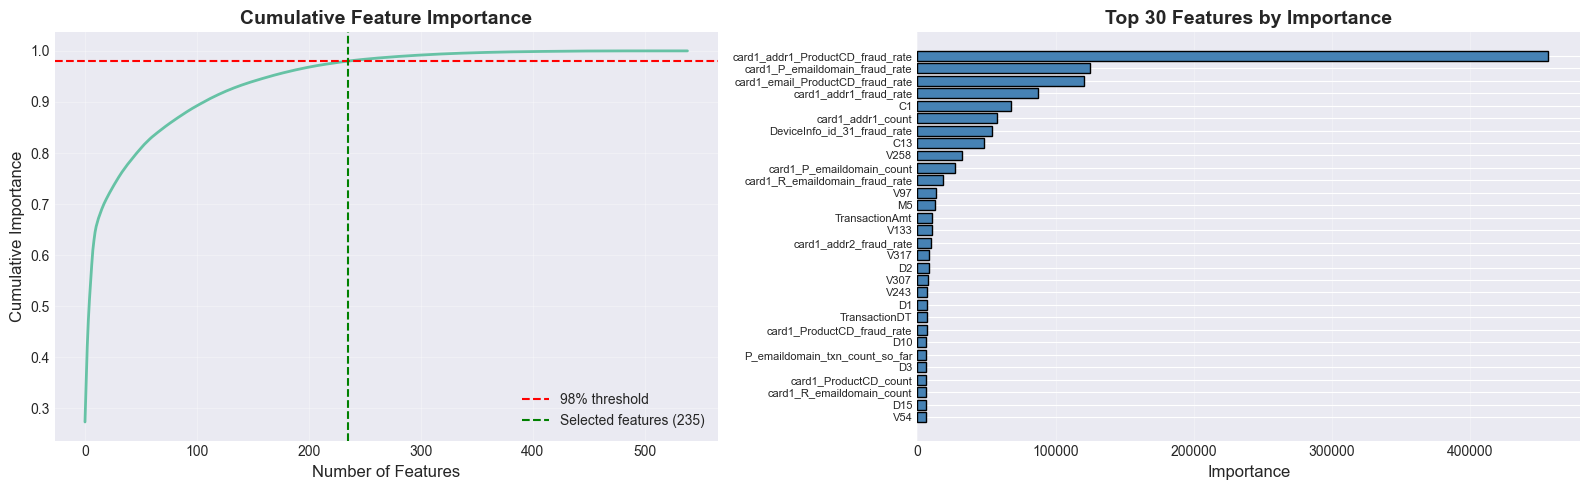

In [12]:
# Visualize cumulative importance
importance_df = selector.feature_importance.copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative importance
ax = axes[0]
ax.plot(range(len(importance_df)), importance_df['cumulative_importance'].values, linewidth=2)
ax.axhline(y=0.98, color='r', linestyle='--', label='98% threshold')
ax.axvline(x=len(selected_features), color='g', linestyle='--', label=f'Selected features ({len(selected_features)})')
ax.set_xlabel('Number of Features', fontsize=12)
ax.set_ylabel('Cumulative Importance', fontsize=12)
ax.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Top 30 features
ax = axes[1]
top_30 = importance_df.head(30)
ax.barh(range(len(top_30)), top_30['importance'].values, color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['feature'].values, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 30 Features by Importance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 10. Test Different Importance Thresholds

In [13]:
# Test different thresholds
print("Testing different importance thresholds...\n")

thresholds = [0.90, 0.95, 0.98, 0.99]
threshold_results = []

for threshold in thresholds:
    print(f"\nThreshold: {threshold*100}%")
    print("-" * 50)
    
    # Select features
    features_above_threshold = importance_df[
        importance_df['cumulative_importance'] <= threshold
    ]['feature'].tolist()
    
    # Ensure minimum features
    if len(features_above_threshold) < 50:
        features_above_threshold = importance_df['feature'].head(50).tolist()
    
    X_tr = X_train_step1[features_above_threshold]
    X_vl = X_val_step1[features_above_threshold]
    
    # Train model
    model = LGBMBaseline(params=best_params)
    metrics = model.train(
        X_tr, y_train,
        X_vl, y_val,
        num_boost_round=1000,
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    threshold_results.append({
        'threshold': threshold,
        'n_features': len(features_above_threshold),
        'auc': metrics['val_auc']
    })
    
    print(f"Features: {len(features_above_threshold)}")
    print(f"AUC: {metrics['val_auc']:.6f}")
    print(f"Change from baseline: {metrics['val_auc'] - baseline_auc:+.6f}")

# Convert to dataframe
threshold_df = pd.DataFrame(threshold_results)
print("\n" + "="*70)
print("THRESHOLD COMPARISON")
print("="*70)
print(threshold_df.to_string(index=False))
print("="*70)

Testing different importance thresholds...


Threshold: 90.0%
--------------------------------------------------
TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 107

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 107

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[444]	train's auc: 0.998813	valid's auc: 0.982308
Early stopping, best iteration is:
[444]	train's auc: 0.998813	valid's auc: 0.982308

TRAINING COMPLETE

Best iteration: 444
Training AUC:   0.998813
Validation AUC: 0.982308

Features: 107
AUC: 0.982308
Change from baseline: -0.001344

Threshold: 95.0%
--------------------------------------------------
TRAINING LIGHTGBM B

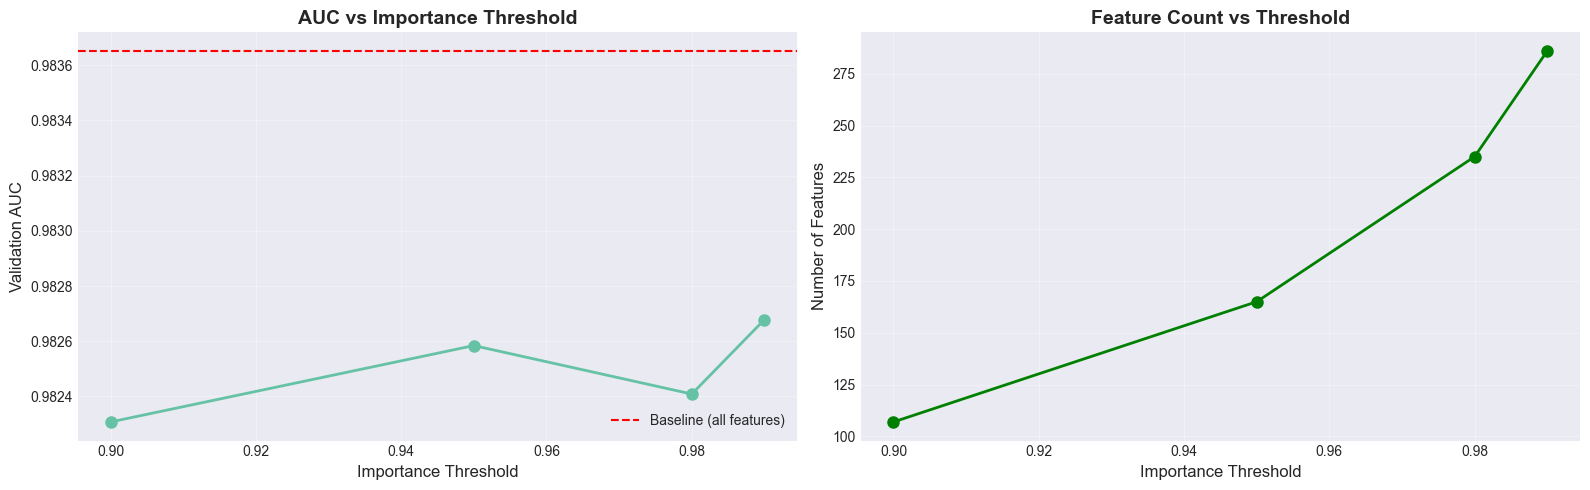

In [14]:
# Visualize threshold comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# AUC vs threshold
ax = axes[0]
ax.plot(threshold_df['threshold'], threshold_df['auc'], marker='o', linewidth=2, markersize=8)
ax.axhline(y=baseline_auc, color='r', linestyle='--', label='Baseline (all features)')
ax.set_xlabel('Importance Threshold', fontsize=12)
ax.set_ylabel('Validation AUC', fontsize=12)
ax.set_title('AUC vs Importance Threshold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Features vs threshold
ax = axes[1]
ax.plot(threshold_df['threshold'], threshold_df['n_features'], marker='o', linewidth=2, markersize=8, color='green')
ax.set_xlabel('Importance Threshold', fontsize=12)
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Count vs Threshold', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Performance Comparison

FEATURE SELECTION RESULTS

Baseline (all features):            0.983652 (755 features)
After correlation removal:          0.983140 (539 features)
After importance selection (98%):   0.982409 (235 features)
Best threshold (99.0%):           0.982679 (286 features)

Best improvement: -0.000512
Feature reduction: 755 → 286 (62.1%)
Training speedup: ~2.6x faster


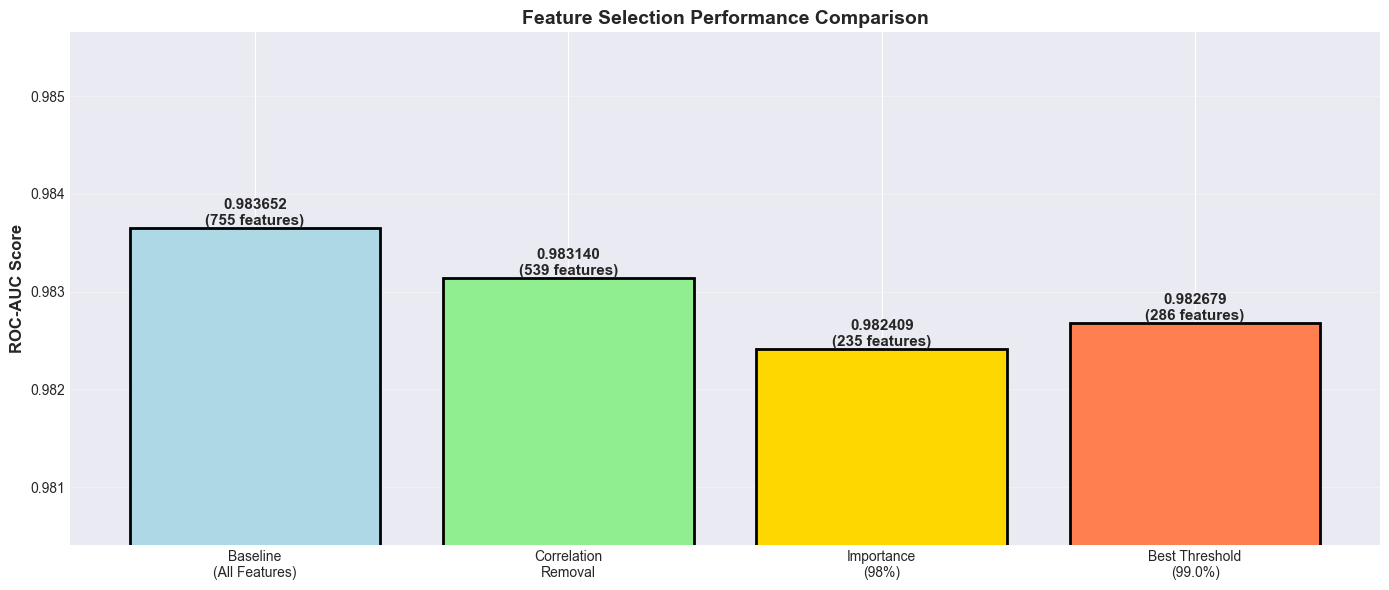

In [15]:
# Find best threshold
best_threshold_idx = threshold_df['auc'].idxmax()
best_threshold = threshold_df.loc[best_threshold_idx, 'threshold']
best_threshold_auc = threshold_df.loc[best_threshold_idx, 'auc']
best_threshold_features = threshold_df.loc[best_threshold_idx, 'n_features']

print("="*70)
print("FEATURE SELECTION RESULTS")
print("="*70)

print(f"\nBaseline (all features):            {baseline_auc:.6f} ({X_train.shape[1]} features)")
print(f"After correlation removal:          {auc_step1:.6f} ({X_train_step1.shape[1]} features)")
print(f"After importance selection (98%):   {auc_step2:.6f} ({X_train_step2.shape[1]} features)")
print(f"Best threshold ({best_threshold*100}%):           {best_threshold_auc:.6f} ({best_threshold_features} features)")

print(f"\nBest improvement: {max(auc_step1, auc_step2, best_threshold_auc) - baseline_auc:+.6f}")
print(f"Feature reduction: {X_train.shape[1]} → {best_threshold_features} ({(1-best_threshold_features/X_train.shape[1])*100:.1f}%)")
print(f"Training speedup: ~{X_train.shape[1]/best_threshold_features:.1f}x faster")

print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

models = ['Baseline\n(All Features)', 'Correlation\nRemoval', 'Importance\n(98%)', f'Best Threshold\n({best_threshold*100}%)']
scores = [baseline_auc, auc_step1, auc_step2, best_threshold_auc]
n_features = [X_train.shape[1], X_train_step1.shape[1], X_train_step2.shape[1], best_threshold_features]
colors = ['lightblue', 'lightgreen', 'gold', 'coral']

bars = ax.bar(models, scores, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, score, n_feat in zip(bars, scores, n_features):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.6f}\n({n_feat} features)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Feature Selection Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(min(scores) - 0.002, max(scores) + 0.002)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 12. Feature Category Analysis

FEATURE CATEGORY ANALYSIS

Category           Total   Selected       Rate
----------------------------------------------------------------------
Aggregation           71         44      62.0%
Interaction           70         41      58.6%
Missing              104         11      10.6%
Original             435        151      34.7%
Temporal              75         39      52.0%


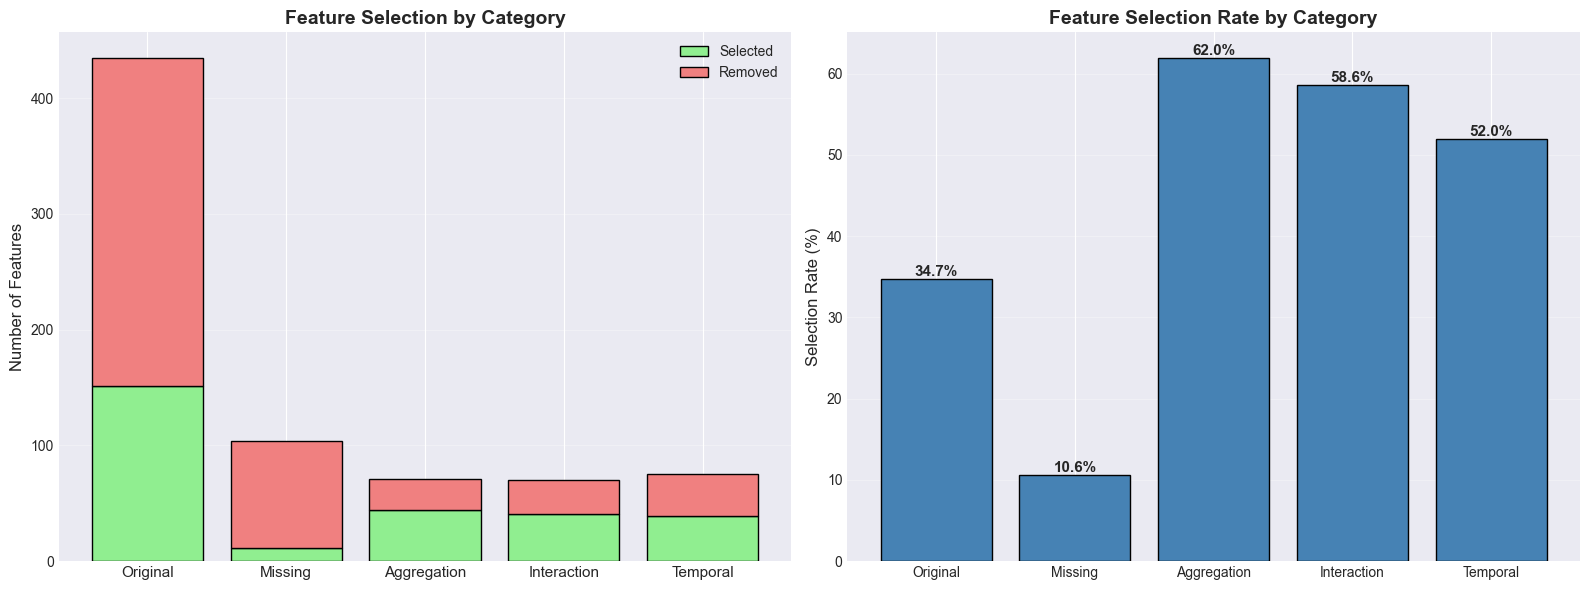

In [16]:
# Analyze which feature categories were kept/removed
final_selected = importance_df[
    importance_df['cumulative_importance'] <= best_threshold
]['feature'].tolist()

if len(final_selected) < 50:
    final_selected = importance_df['feature'].head(50).tolist()

# Categorize features
def categorize_feature(feat):
    if feat in missing_feature_names:
        return 'Missing'
    elif feat in agg_feature_names:
        return 'Aggregation'
    elif feat in interaction_feature_names:
        return 'Interaction'
    elif feat in temporal_feature_names:
        return 'Temporal'
    else:
        return 'Original'

# Count by category
category_counts_all = {}
category_counts_selected = {}

for feat in X_train.columns:
    cat = categorize_feature(feat)
    category_counts_all[cat] = category_counts_all.get(cat, 0) + 1
    if feat in final_selected:
        category_counts_selected[cat] = category_counts_selected.get(cat, 0) + 1

# Calculate selection rates
selection_rates = {cat: (category_counts_selected.get(cat, 0) / category_counts_all[cat] * 100) 
                   for cat in category_counts_all.keys()}

print("="*70)
print("FEATURE CATEGORY ANALYSIS")
print("="*70)
print(f"\n{'Category':<15} {'Total':>8} {'Selected':>10} {'Rate':>10}")
print("-" * 70)
for cat in sorted(category_counts_all.keys()):
    total = category_counts_all[cat]
    selected = category_counts_selected.get(cat, 0)
    rate = selection_rates[cat]
    print(f"{cat:<15} {total:>8} {selected:>10} {rate:>9.1f}%")
print("="*70)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
ax = axes[0]
categories = list(category_counts_all.keys())
selected_counts = [category_counts_selected.get(cat, 0) for cat in categories]
removed_counts = [category_counts_all[cat] - category_counts_selected.get(cat, 0) for cat in categories]

x = range(len(categories))
ax.bar(x, selected_counts, label='Selected', color='lightgreen', edgecolor='black')
ax.bar(x, removed_counts, bottom=selected_counts, label='Removed', color='lightcoral', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Selection by Category', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Selection rate
ax = axes[1]
rates = [selection_rates[cat] for cat in categories]
bars = ax.bar(categories, rates, color='steelblue', edgecolor='black')
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)
ax.set_ylabel('Selection Rate (%)', fontsize=12)
ax.set_title('Feature Selection Rate by Category', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 13. Train Final Model with Selected Features

In [17]:
# Train final model with best feature set
print("Training final model with optimally selected features...\n")

X_train_final = X_train_step1[final_selected]
X_val_final = X_val_step1[final_selected]

model_final = LGBMBaseline(params=best_params)
metrics_final = model_final.train(
    X_train_final, y_train,
    X_val_final, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

auc_final = metrics_final['val_auc']

print(f"\n{'='*70}")
print(f"FINAL MODEL (SELECTED FEATURES)")
print(f"{'='*70}")
print(f"Features: {len(final_selected)}")
print(f"Validation AUC: {auc_final:.6f}")
print(f"Training AUC: {metrics_final['train_auc']:.6f}")
print(f"Improvement over baseline: {auc_final - baseline_auc:+.6f}")
print(f"{'='*70}")

Training final model with optimally selected features...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 286

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 286

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.992554	valid's auc: 0.979374
[100]	train's auc: 0.992554	valid's auc: 0.979374
[200]	train's auc: 0.995516	valid's auc: 0.981274
[200]	train's auc: 0.995516	valid's auc: 0.981274
[300]	train's auc: 0.997433	valid's auc: 0.982311
[300]	train's auc: 0.997433	valid's auc: 0.982311
[400]	train's auc: 0.998482	valid's auc: 0.982633
[400]	train's auc: 0.998482	valid's auc: 0.982633
[500]	train's auc: 0.999156	valid's auc: 0.982607
[500]	train'

## 14. Feature Importance of Final Model

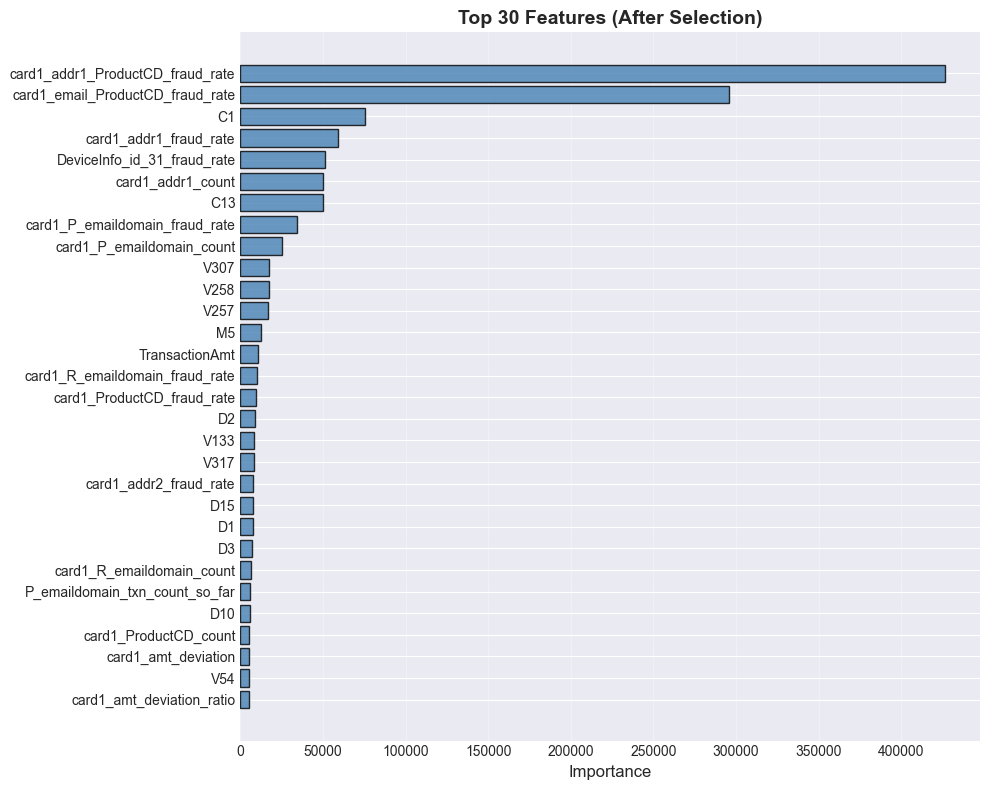

In [18]:
# Plot feature importance for final model
plot_feature_importance(
    model_final.feature_importance,
    top_n=30,
    title="Top 30 Features (After Selection)"
)

In [19]:
# Compare top features before and after selection
baseline_importance = baseline_model.get_feature_importance(top_n=30)
final_importance = model_final.get_feature_importance(top_n=30)

print("Top 20 Features Comparison:\n")
print("="*100)
print(f"{'Rank':<6} {'Baseline (All Features)':<45} {'After Selection':<45}")
print("="*100)

for i in range(20):
    baseline_feat = baseline_importance.iloc[i]['feature'] if i < len(baseline_importance) else ''
    final_feat = final_importance.iloc[i]['feature'] if i < len(final_importance) else ''
    print(f"{i+1:<6} {baseline_feat:<45} {final_feat:<45}")

print("="*100)

Top 20 Features Comparison:

Rank   Baseline (All Features)                       After Selection                              
1      card1_addr1_ProductCD_fraud_rate              card1_addr1_ProductCD_fraud_rate             
2      card1_email_ProductCD_fraud_rate              card1_email_ProductCD_fraud_rate             
3      C1                                            C1                                           
4      DeviceInfo_id_31_fraud_rate                   card1_addr1_fraud_rate                       
5      card1_addr1_ProductCD_count                   DeviceInfo_id_31_fraud_rate                  
6      C14                                           card1_addr1_count                            
7      card1_R_emaildomain_fraud_rate                C13                                          
8      card1_P_emaildomain_fraud_rate                card1_P_emaildomain_fraud_rate               
9      card1_addr1_fraud_rate                        card1_P_emaildomain_count  

## 15. Save Selected Features

In [20]:
# Save selected features
os.makedirs('../models', exist_ok=True)

# Save feature list
with open('../models/selected_features.json', 'w') as f:
    json.dump({
        'features': final_selected,
        'n_features': len(final_selected),
        'threshold': best_threshold,
        'auc': auc_final,
        'improvement': float(auc_final - baseline_auc)
    }, f, indent=4)

# Save model
model_final.save_model('../models/lgbm_feature_selected.txt')

print("✓ Selected features and model saved successfully!")
print("\nSaved files:")
print("  • ../models/selected_features.json")
print("  • ../models/lgbm_feature_selected.txt")
print(f"\nFeatures: {len(final_selected)}")
print(f"Reduction: {X_train.shape[1]} → {len(final_selected)} ({(1-len(final_selected)/X_train.shape[1])*100:.1f}%)")

✓ Model saved: ../models/lgbm_feature_selected.txt
✓ Metadata saved: ../models/lgbm_feature_selected_metadata.json
✓ Selected features and model saved successfully!

Saved files:
  • ../models/selected_features.json
  • ../models/lgbm_feature_selected.txt

Features: 286
Reduction: 755 → 286 (62.1%)


## 16. ROC Curve Comparison

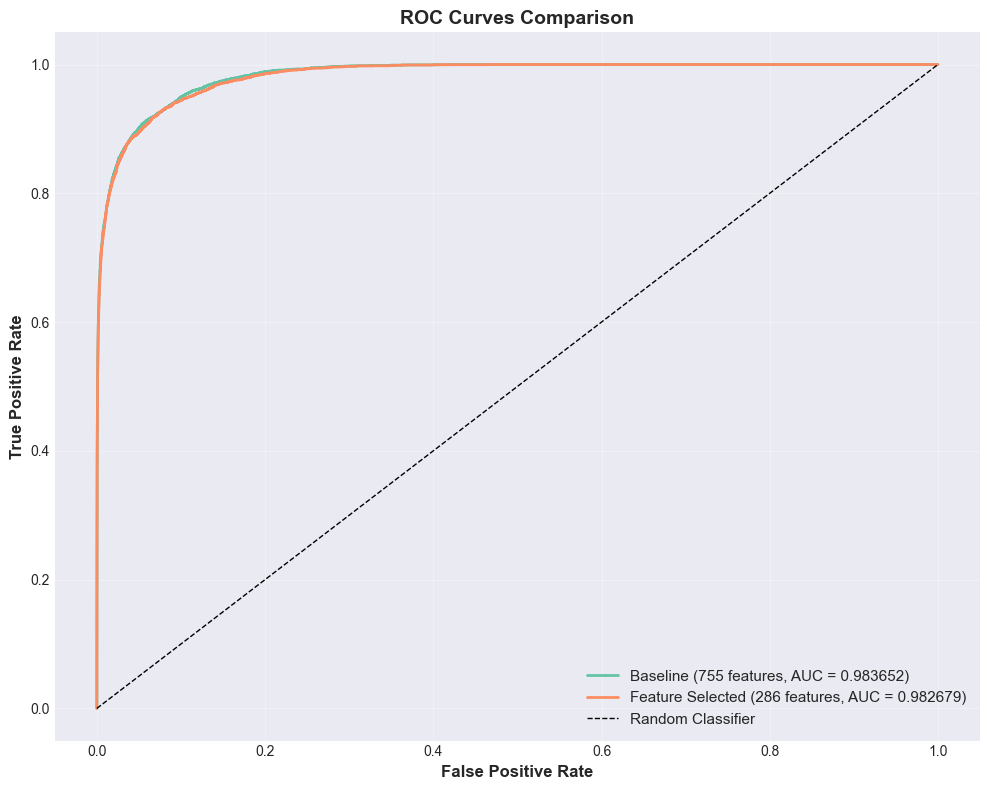

In [21]:
# Compare ROC curves
from sklearn.metrics import roc_curve, auc

baseline_pred = baseline_model.predict(X_val)
final_pred = model_final.predict(X_val_final)

fig, ax = plt.subplots(figsize=(10, 8))

# Baseline
fpr_base, tpr_base, _ = roc_curve(y_val, baseline_pred)
roc_auc_base = auc(fpr_base, tpr_base)
ax.plot(fpr_base, tpr_base, linewidth=2, label=f'Baseline ({X_train.shape[1]} features, AUC = {roc_auc_base:.6f})')

# Final
fpr_final, tpr_final, _ = roc_curve(y_val, final_pred)
roc_auc_final = auc(fpr_final, tpr_final)
ax.plot(fpr_final, tpr_final, linewidth=2, label=f'Feature Selected ({len(final_selected)} features, AUC = {roc_auc_final:.6f})')

# Diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 17. Summary

In [22]:
print("="*70)
print("MILESTONE 12: FEATURE SELECTION - COMPLETE")
print("="*70)

print("\n📊 FEATURE REDUCTION:")
print(f"  • Original features:                 {X_train.shape[1]}")
print(f"  • After correlation removal:         {X_train_step1.shape[1]}")
print(f"  • Final selected features:           {len(final_selected)}")
print(f"  • Total reduction:                   {(1-len(final_selected)/X_train.shape[1])*100:.1f}%")
print(f"  • Training speedup:                  ~{X_train.shape[1]/len(final_selected):.1f}x")

print("\n🎯 PERFORMANCE:")
print(f"  • Baseline AUC (all features):       {baseline_auc:.6f}")
print(f"  • Final AUC (selected features):     {auc_final:.6f}")
print(f"  • Change:                            {auc_final - baseline_auc:+.6f}")
print(f"  • Best threshold:                    {best_threshold*100}%")

print("\n🔍 SELECTION METHODS:")
print("  • Removed single-value features")
print(f"  • Removed correlated features (>0.95 correlation)")
print(f"  • Selected by cumulative importance ({best_threshold*100}%)")

print("\n📈 FEATURE CATEGORIES (Selection Rates):")
for cat in sorted(category_counts_all.keys()):
    rate = selection_rates[cat]
    selected = category_counts_selected.get(cat, 0)
    total = category_counts_all[cat]
    print(f"  • {cat:<12} {selected:>3}/{total:<3} ({rate:>5.1f}%)")

print("\n✅ MILESTONE 12 COMPLETE")

print("\n🚀 NEXT STEPS (Milestone 13):")
print("  • M13: Advanced modeling (stacking, blending, ensembles)")
print("  • Combine multiple models for better predictions")
print("  • Target: Reach 0.945+ (Top 10%)")

print("\n" + "="*70)
print("✓ FEATURE SELECTION COMPLETE")
print("="*70)

MILESTONE 12: FEATURE SELECTION - COMPLETE

📊 FEATURE REDUCTION:
  • Original features:                 755
  • After correlation removal:         539
  • Final selected features:           286
  • Total reduction:                   62.1%
  • Training speedup:                  ~2.6x

🎯 PERFORMANCE:
  • Baseline AUC (all features):       0.983652
  • Final AUC (selected features):     0.982679
  • Change:                            -0.000974
  • Best threshold:                    99.0%

🔍 SELECTION METHODS:
  • Removed single-value features
  • Removed correlated features (>0.95 correlation)
  • Selected by cumulative importance (99.0%)

📈 FEATURE CATEGORIES (Selection Rates):
  • Aggregation   44/71  ( 62.0%)
  • Interaction   41/70  ( 58.6%)
  • Missing       11/104 ( 10.6%)
  • Original     151/435 ( 34.7%)
  • Temporal      39/75  ( 52.0%)

✅ MILESTONE 12 COMPLETE

🚀 NEXT STEPS (Milestone 13):
  • M13: Advanced modeling (stacking, blending, ensembles)
  • Combine multiple models for